# Watershed Distance Transform for 3D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno
import argparse

import numpy as np
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler

from deepcell.model_zoo import bn_feature_net_3D
from deepcell.model_zoo import bn_feature_net_skip_3D
from deepcell.training import train_model_conv
from deepcell.training import train_model_sample

Using TensorFlow backend.


## Load the Training Data

In [2]:
DATA_OUTPUT_MODE = 'conv'
PADDING = 'same'
RESIZE = False
RESHAPE_SIZE = 256
NUM_FRAMES = 15  # get first N frames from each training folder
BINS = 4  # number of distance bins to classify
EROSION = 1  # number of pixels to erode edges

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/MouseBrain/generic'
DATA_FILE = 'MouseBrain_3d'

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 3 if IS_CHANNELS_FIRST else 2
COL_AXIS = 4 if IS_CHANNELS_FIRST else 3
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 4

# create these directories if they do not exist
for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
        print('Created new directory:', os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, DATA_FILE),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=None,  # all training directories
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    num_frames=NUM_FRAMES,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw_parts',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz'):
    print('\nData saved to', os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')


Data saved to /data/npz_data/cells/MouseBrain/generic/MouseBrain_3d.npz


## Fully Convolutional Training

In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 3
batch_size = 1
frames_per_batch = 3
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.95)

# save the size of the input data for batch_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    batch_shape = (batch_size, X.shape[CHANNEL_AXIS], frames_per_batch, size[0], size[1])
    input_shape = (X.shape[CHANNEL_AXIS], frames_per_batch, size[0], size[1])

else:
    batch_shape = (batch_size, frames_per_batch, size[0], size[1], X.shape[CHANNEL_AXIS])
    input_shape = (frames_per_batch, size[0], size[1], X.shape[CHANNEL_AXIS])

X.shape: (220, 15, 256, 256, 1)
y.shape: (220, 15, 256, 256, 1)


In [5]:
# First, create a foreground/background separation model

# Instantiate the model
fgbg_model = bn_feature_net_skip_3D(
    receptive_field=61,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_frames=frames_per_batch,
    n_skips=2,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=input_shape,
    multires=False,
    last_only=False,
    norm_method='whole_image')

# Train the model
train_model_conv(
    model=fgbg_model,
    expt='conv_fgbg',
    transform=None,
    skip=2,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    frames_per_batch=frames_per_batch,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=rate_scheduler(lr=0.01, decay=0.95),
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (None, 3, 256, 256, 2)
Number of Classes: 2
Epoch 1/3
197/198 [============================>.] - ETA: 0s - loss: 0.6969 - model_1_loss: 0.2269 - model_2_loss: 0.2234 - model_3_loss: 0.2197 - model_1_acc: 0.9119 - model_2_acc: 0.9089 - model_3_acc: 0.9074
Epoch 00001: val_loss improved from inf to 0.73252, saving model to /data/models/cells/MouseBrain/generic/2018-09-04_MouseBrain_3d_conv_fgbg.h5
198/198 [==============================] - 134s 676ms/step - loss: 0.6958 - model_1_loss: 0.2265 - model_2_loss: 0.2231 - model_3_loss: 0.2193 - model_1_acc: 0.9118 - model_2_acc: 0.9088 - model_3_acc: 0.9073 - val_loss: 0.7325 - val_model_1_loss: 0.2858 - val_model_2_loss: 0.2148 - val_model_3_loss: 0.2051 - val_model_1_acc: 0.9472 - val_model_2_acc: 0.9386 - val_model_3_acc: 0.9347
Epoch 2/3
197/198 [============================>.] -

In [6]:
# Instantiate the model
watershed_model = bn_feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=61,
    n_skips=2,
    n_features=BINS,
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False,
    input_shape=input_shape,
    norm_method='whole_image')

# Train the model
train_model_conv(
    model=watershed_model,
    expt='conv_watershed',
    transform='watershed',
    distance_bins=BINS,
    erosion_width=EROSION,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    skip=2,
    frames_per_batch=frames_per_batch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (None, 3, 256, 256, 4)
Number of Classes: 4
Epoch 1/3
197/198 [============================>.] - ETA: 0s - loss: 2.9327 - model_5_loss: 0.9455 - model_6_loss: 0.9694 - model_7_loss: 0.9637 - model_5_acc: 0.8845 - model_6_acc: 0.8684 - model_7_acc: 0.8734
Epoch 00001: val_loss improved from inf to 3.61943, saving model to /data/models/cells/MouseBrain/generic/2018-09-04_MouseBrain_3d_conv_watershed.h5
198/198 [==============================] - 159s 805ms/step - loss: 2.9299 - model_5_loss: 0.9444 - model_6_loss: 0.9684 - model_7_loss: 0.9629 - model_5_acc: 0.8847 - model_6_acc: 0.8686 - model_7_acc: 0.8736 - val_loss: 3.6194 - val_model_5_loss: 0.9053 - val_model_6_loss: 1.4066 - val_model_7_loss: 1.2532 - val_model_5_acc: 0.9140 - val_model_6_acc: 0.8353 - val_model_7_acc: 0.8379
Epoch 2/3
197/198 [============================

In [8]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')

train_dict, test_dict = get_data(training_data_file, mode='conv', seed=21)

# too many batches at once causes OOM
X_test, y_test = test_dict['X'][:4], test_dict['y'][:4]
print(X_test.shape)

input_shape = X_test.shape[1:]

# To predict on variable number of frames
# we need to re-instantiate model and load weights
watershed_weights_file = '2018-09-04_MouseBrain_3d_conv_watershed.h5'
watershed_weights_file = os.path.join(MODEL_DIR, PREFIX, watershed_weights_file)

fg_bg_weights_file = '2018-09-04_MouseBrain_3d_conv_fgbg.h5'
fg_bg_weights_file = os.path.join(MODEL_DIR, PREFIX, fg_bg_weights_file)

fgbg_model = bn_feature_net_skip_3D(
    receptive_field=61,
    n_features=2, 
    n_frames=3,
    n_skips=2,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=input_shape,
    multires=False,
    last_only=False,
    norm_method='whole_image')
fgbg_model.load_weights(fg_bg_weights_file)

watershed_model = bn_feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=61,
    n_skips=2,
    n_features=BINS,
    n_frames=3,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False,
    input_shape=input_shape,
    norm_method='whole_image')
watershed_model.load_weights(watershed_weights_file)

(4, 15, 256, 256, 1)


In [9]:
test_images = watershed_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=CHANNEL_AXIS - 1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=CHANNEL_AXIS)

print('watershed argmax shape:', argmax_images.shape)

watershed transform shape: (4, 15, 256, 256, 4)
segmentation mask shape: (4, 15, 256, 256, 2)
watershed argmax shape: (4, 15, 256, 256, 1)


In [10]:
# threshold the foreground/background
# and remove back ground from watershed transform
threshold = 0.5
if IS_CHANNELS_FIRST:
    fg_thresh = test_images_fgbg[:, 1, :, :, :] > threshold
else:
    fg_thresh = test_images_fgbg[:, :, :, :, 1] > threshold

fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [11]:
# Apply watershed method with the distance transform as seed
from scipy import ndimage
from scipy.ndimage.morphology import distance_transform_edt
from skimage.morphology import watershed, opening, closing
from skimage.feature import peak_local_max
from skimage.morphology import erosion, ball

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    if IS_CHANNELS_FIRST:
        image = fg_thresh[i, 0, :, :, :]
        distance = argmax_images_post_fgbg[i, 0, :, :, :]
    else:
        image = fg_thresh[i, :, :, :, 0]
        distance = argmax_images_post_fgbg[i, :, :, :, 0]

    local_maxi = peak_local_max(
        test_images[i, :, :, :, -1],
        min_distance=10,
        threshold_abs=0.05,
        indices=False,
        labels=image,
        exclude_border=False)

    markers = ndimage.label(local_maxi)[0]
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=CHANNEL_AXIS)

# Plot the results

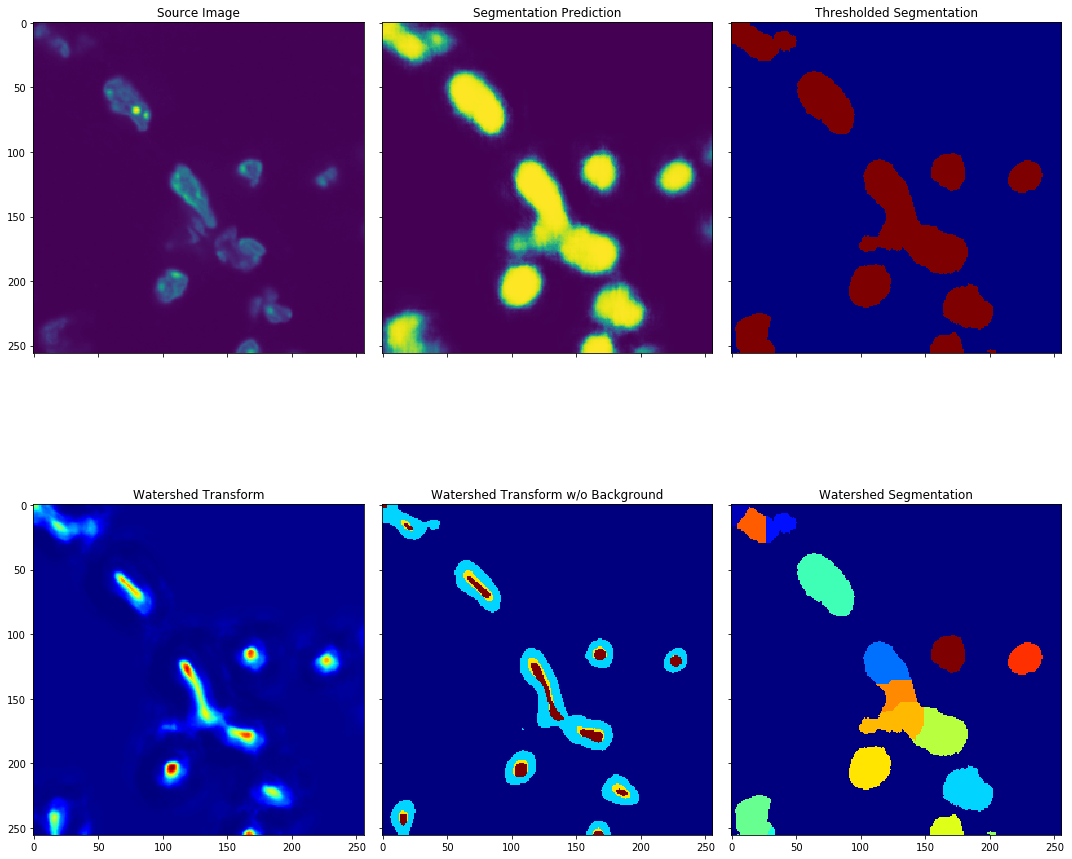

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = 0
frame = 6

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, :, :, 0], cmap='jet')
ax[2].set_title('Thresholded Segmentation')

ax[3].imshow(test_images[index, frame, :, :, 3], cmap='jet')
ax[3].set_title('Watershed Transform')

ax[4].imshow(argmax_images_post_fgbg[index, frame, :, :, 0], cmap='jet')
ax[4].set_title('Watershed Transform w/o Background')

ax[5].imshow(watershed_images[index, frame, :, :, 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

In [13]:
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

HTML(get_js_video(watershed_images[:, :, :, :, [-1]], batch=0))